<a href="https://colab.research.google.com/github/seyrankhademi/ResNet_CIFAR10/blob/master/CIFAR10_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Reproducing CIFAR10 Experiment in the ResNet paper

In this notebook we reproduce Table 6 in 
[original ResNet paper](https://arxiv.org/abs/1512.03385), 
i.e. the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)
experiment in the original ResNet paper 
published in CVPR 2016 conference andreceived 
more than 38k citations so far. This ```Pytorch```
implementation started from the code in 
[torchvision tutorial]( https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py) and the implementation by 
[Yerlan Idelbayev](https://github.com/akamaster/pytorch_resnet_cifar10). 
We developed the code in Jupyter notebook and it 
is compatible with Google Colab platform to be used with GPU. 


---


## How/Why ResNet models are working?
There have been rigorous attempts to make deeper 
convolutional neural networks (CNN) since their 
advent in [2012](https://dl.acm.org/doi/10.1145/3065386) as 
the performance is believed to be tightly related to the  [complexity of the network](https://arxiv.org/abs/1409.1556). 
A major obstacle in training deeper neural networks is the well-known  [vanishing gradient](http://proceedings.mlr.press/v9/glorot10a.html) problem. 
As the layers are added to the network the 
multiplying gradients make the overall gradient 
infinitesimal which in turn causes very slow 
convergence if at all. 

The same training difficulties with *exploding gradients* 
can also hinder the learning process once layers are stacked in the 
neural networks. In an attempt to tackle the vanishing/exploding 
gradients in deeper networks, in 2015, a novel CNN architecture 
is introduced, which won the ImageNet classification 
competition in [ILSVRC 2015](https://arxiv.org/abs/1502.01852) by 
a good margin (2.84 %) from its competitors. 

The intuition behind the ResNet architecture is 
rather simple: Assuming that a neural network unit 
can learn any function, asymptotically, then it can learn the identity function as well. Why is it 
important to learn the identity function? The 
answer lies in the ResNet architecture. An example 
of a residual unit is shown in the following figure, 
taken from the paper. The input to the residual 
block is $X$ and the output is $\mathcal{F}(X)+X$, 
therefore, by learning $\mathcal{F}(X)=0$ this basic 
block is bypassed during the training process,which is equivalent to identity mapping. A cascade of these residual blocks is used 
to create very deep CNN models with more than 100 
layers as presented in the original ResNet paper. 

<img align="center" src="https://drive.google.com/uc?id=1c4QvJN4H_GdGWNM-vW46j_JIG64CD_mD" />

Note that a plain CNN model (without residual connections)posses the same solution space as the counterpart network 
with the residual connections, however, it is argued in 
[original ResNet paper](https://arxiv.org/abs/1512.03385) that "If the optimal function is closer to an identity
mapping than to a zero mapping, it should be easier for the
solver to find the perturbations with reference to an identity
mapping , than to learn the function like a new one.
" This hypothesis is backed up in the paper with 
several experiments in different datasets.
In essence, the ResNet model gives a chance to the 
network to learn "flexible" depth for the CNN model 
and avoid the vanishing/exploding gradients if that 
hinders the optimization process. 


---


## Experiment Setup 
The authors train and test six different ResNet architectures for 
[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) and 
compare the results in Table 6 in the original paper.CIFAR10 image classification dataset consists of 50k training 
images and 10k testing images in 10 classes. The network inputs 
are $32\times 32$ images, with the per-pixel mean subtracted. 
The first layer is $3\times 3$ convolutions.
There are totally $6n+2$ residual blocks stacked, 
where replacing $n$ with $3,5,7,9,18,200$ produces 
networks of depth $20,32,44,56,110,1202$ respectively. 
The architecture is summarized in the following table 
taken from the paper, where three columns represent 
three different feature-map sizes. 

<img align="center" src="https://drive.google.com/uc?id=1W_k5HZ8lS9_h9BUOx9R0AvZPTqRVDSlT" />

Note that training in the original paper uses 
validation set to select the best performing model, 
however, this implementation does not use 
validation set to select the model, rather we 
use the train and validation set for training 
and testing the performance of a single model 
(reported in the paper). Also to train ResNet1202, 
you need 16GB memory on GPU, therefore, you can 
not run it on the Google CoLab platform.
For the rest,we use the same setting as 
described in the original paper and we 
reproduce the following results in terms 
of performance error: 

| MODEL | PAPER   | OURS
|------|------||
|   ResNet-20  | 8.75|7.92|
|   ResNet-32  |7.51 |7.27|
|   ResNet-44  |7.17|6.88|
|   ResNet-56  |6.97 |7.58|
|   ResNet-110  | 6.43|6.54|
|   ResNet-1202  | 7.93|?|

Except for the ResNet1202, we reproduced the 
experiments with comparable or better results. 



---


## Running the Experiment on Google Colab
This notebook is running remotely on the Google Colab platform, therefore to save and access the trained model and checkpoints in your local computer you may need to mount the Google drive (gdrive). I used the following code snippet to set up a local drive on my computer. You need to do the same by specifying the path to your project directory.  Therefore, you need to create a directory in your gdrive for this project and change the paths in the code to your directory.

In [0]:
# First we need to mount the Google drive 
import os
from google.colab import drive
drive.mount('/content/gdrive')
# Here specify the path to your directory
!ls "/content/gdrive/My Drive/CIFAR10_ResNet" 
root_path = 'gdrive/My Drive/CIFAR10_ResNet' 
path ='/content/gdrive/My Drive/CIFAR10_ResNet'
os.chdir(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
data		   pretrained_models.zip  README.md  run.sh	test.png
pretrained_models  __pycache__		  resnet.py  save_temp	trainer.py


---
## ResNet Architecture

In the following code cell, the ResNet model is defined with all the related functions for initialization of the weights, the residual block and skip connections are implemented as presented in the original paper. By executing the cell you can see all possible ResNet architecture, with the number of their learning parameters and layers, that we use in this experiment. 

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import resnet
# We define all the classes and function regarding the ResNet architecture in this code cell
__all__ = ['ResNet', 'resnet20', 'resnet32', 'resnet44', 'resnet56', 'resnet110', 'resnet1202']
 
def _weights_init(m):
    """
        Initialization of CNN weights
    """
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)


class LambdaLayer(nn.Module):
    """
      Identity mapping between ResNet blocks with diffrenet size feature map
    """
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

# A basic block as shown in Fig.3 (right) in the paper consists of two convolutional blocks, each followed by a Bach-Norm layer. 
# Every basic block is shortcuted in ResNet architecture to construct f(x)+x module. 
# Expansion for option 'A' in the paper is equal to identity with extra zero entries padded
# for increasing dimensions between layers with different feature map size. This option introduces no extra parameter. 
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 experiment, ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Stack of 3 times 2*n (n is the number of basic blocks) layers are used for making the ResNet model, 
# where each 2n layers have feature maps of size {16,32,64}, respectively. 
# The subsampling is performed by convolutions with a stride of 2.
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])


def resnet32():
    return ResNet(BasicBlock, [5, 5, 5])


def resnet44():
    return ResNet(BasicBlock, [7, 7, 7])


def resnet56():
    return ResNet(BasicBlock, [9, 9, 9])


def resnet110():
    return ResNet(BasicBlock, [18, 18, 18])


def resnet1202():
    return ResNet(BasicBlock, [200, 200, 200])


def test(net):
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))


if __name__ == "__main__":
    for net_name in __all__:
        if net_name.startswith('resnet'):
            print(net_name)
            test(globals()[net_name]())
            print()

resnet20
Total number of params 269722
Total layers 20

resnet32
Total number of params 464154
Total layers 32

resnet44
Total number of params 658586
Total layers 44

resnet56
Total number of params 853018
Total layers 56

resnet110
Total number of params 1727962
Total layers 110

resnet1202
Total number of params 19421274
Total layers 1202




---
# Hyperparameter Setting

We define a class referred to as ```MyResNetArgs```in the following to assign the hyperparameters such as a number of training epochs, learning rate, momentum, batch size, etc. to the training function. The objects of this class are initialized inherently once created with a void argument. 

In [0]:
 class MyResNetArgs:
   """
    Passing the hyperparameters to the model
   """
   def __init__(self, arch='resnet20' ,epochs=200, start_epoch=0, batch_size=128, lr=0.1, momentum=0.9, weight_decay=1e-4, print_freq=55,
                 evaluate=0, pretrained=0, half=0, save_dir='save_temp', save_every=10):
        self.save_every = save_every #Saves checkpoints at every specified number of epochs
        self.save_dir = save_dir #The directory used to save the trained models
        self.half = half #use half-precision(16-bit)
        self.evaluate = evaluate #evaluate model on the validation set
        self.pretrained = pretrained #evaluate the pretrained model on the validation set
        self.print_freq = print_freq #print frequency 
        self.weight_decay = weight_decay
        self.momentum = momentum 
        self.lr = lr #Learning rate
        self.batch_size = batch_size 
        self.start_epoch = start_epoch
        self.epochs = epochs
        self.arch = arch #ResNet model


Now we can create an instance of ResNet model and inspect the architecture by printing the model summary. 
One can easily check the difference between different ResNet models to understand the construction units. There are totally $6n+2$ stacked weighted layers, e.g., for ResNet 20, there are 19 convolutional layers plus one fully connected layer. 

In [0]:
from torchsummary import summary
args=MyResNetArgs('resnet20',pretrained=0)
#model = resnet.__dict__[args.arch]()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = resnet.__dict__[args.arch]().to(device)
summary(model, (3,32,32))
best_prec1 = 0

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
        BasicBlock-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 32, 32]           2,304
      BatchNorm2d-11           [-1, 16, 32, 32]              32
       BasicBlock-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           2,304
      BatchNorm2d-14           [-1, 16,



---

# Training and Validation
The next two code blocks (```train``` and ```validate```) are for training and testing the model on the validation set. There is a print module at the end of the train function which prints the top-k classification accuracy and error at specified epochs. The checkpoints are also saved for the training model at ```save_every``` epoch steps, which is initialized to every $10$ epoch by default.  The average accuracy among mini-batches is also recorded for inspection purposes, which is calculated using the ```AverageMeter``` class. 



In [0]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda()
        input_var = input.cuda()
        target_var = target
        if args.half:
            input_var = input_var.half()

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))




In [0]:
def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            if args.half:
                input_var = input_var.half()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()


    print('Test\t  Prec@1: {top1.avg:.3f} (Err: {error:.3f} )\n'
          .format(top1=top1,error=100-top1.avg))

    return top1.avg

def save_checkpoint(state, filename='checkpoint.th'):
    """
    Save the training model
    """
    torch.save(state, filename)


In [0]:

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res




---


## Dataset 

Now that we defined our ResNet model, we need to download and prepare [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset to start the experiment. This is impressively easy with ```
torchvision```. We use ```Dataloader``` to download the train and the validation set. We show random samples in a batch of training images for a better understanding of data. Note that CIFAR-10 images are quite small in size $32 \times 32$. 



Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


           ship           plane             dog            ship           plane           plane            frog            frog


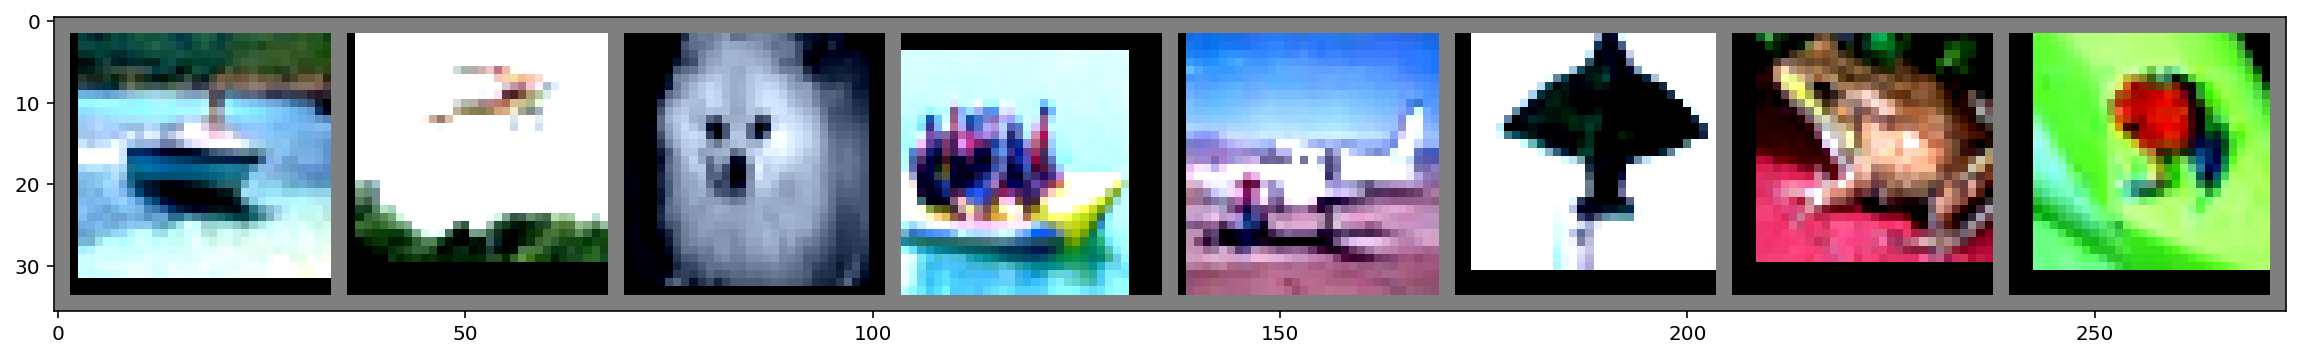

In [0]:
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=args.batch_size, shuffle=True,
        num_workers=4, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=128, shuffle=False,
        num_workers=4, pin_memory=True)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
plt.figure(figsize=(20,10)) 

# show images
imshow(torchvision.utils.make_grid(images[0:8,:,:]))
# print labels
print(' '.join('%15s' % classes[labels[j]] for j in range(8)))




---

# Running the Experiment
Here comes the main script using all the functions explained above to execute the train and the test procedure for a specified ResNet model.

In [0]:
import time

def main():
    global args, best_prec1
    
    # Check the save_dir exists or not
    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)

    model = resnet.__dict__[args.arch]()
    model.cuda()


    # define loss function (criterion) and pptimizer
    criterion = nn.CrossEntropyLoss().cuda()

    if args.half:
        print('half persicion is used.')
        model.half()
        criterion.half()

    optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)

    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                        milestones=[100, 150], last_epoch=args.start_epoch - 1)

    if args.arch in ['resnet1202']:
        # for resnet1202 original paper uses lr=0.01 for first 400 minibatches for warm-up
        # then switch back. In this setup it will correspond for first epoch.
        for param_group in optimizer.param_groups:
            param_group['lr'] = args.lr*0.1


    if args.evaluate:
        print('evalution mode')
        model.load_state_dict(torch.load(os.path.join(args.save_dir, 'model.th')))
        best_prec1 = validate(val_loader, model, criterion)
        return best_prec1

    if args.pretrained:
        print('evalution of pretrained model')
        args.save_dir='pretrained_models'
        pretrained_model= args.arch +'.th'
        model.load_state_dict(torch.load(os.path.join(args.save_dir, pretrained_model)))
        best_prec1 = validate(val_loader, model, criterion)
        return best_prec1

    for epoch in range(args.start_epoch, args.epochs):

        # train for one epoch
        print('Training {} model'.format(args.arch))
        print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
        train(train_loader, model, criterion, optimizer, epoch)
        lr_scheduler.step()

        # evaluate on validation set
        prec1 = validate(val_loader, model, criterion)

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        if epoch > 0 and epoch % args.save_every == 0:
            save_checkpoint(model.state_dict(), filename=os.path.join(args.save_dir, 'checkpoint.th'))
        if is_best:
            save_checkpoint(model.state_dict(), filename=os.path.join(args.save_dir, 'model.th'))

    return best_prec1

Since Google Colab imposes time restriction, we can not loop over all ResNet models to reproduce the results in one go, instead, we run each ResNet model separately by setting the name of the model (e.g. resnet20)  manually in the hyperparameters and record the results once training is finished for the specified network. We saved the trained models in a separate directory to do the inference later. One can try to run the main script several times for each network and report the mean and the variance performance for more reliable results. 

In [0]:
if __name__ == '__main__':
   best_prec1 = main()
   print('The lowest error from {} model after {} epochs is {error:.3f}'.format(args.arch,args.epochs,error=100-best_prec1)) 

We conclude here that the results from the original ResNet paper are reproducible for the CIFAR-10 dataset. 


